> Afin d'améliorer les résultats, transformation de la partie III.A (le passage de photo à sketch) en l'application d'un réseau de neurones (Pix2Pix)

https://www.kaggle.com/code/jclohjc/portrait-to-sketch-pix2pix-conditional-gan/notebook#Model-Testing

### Librairies utilisées

In [1]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import random
from natsort import natsorted, os_sorted, ns
import time
import datetime
import random

### Vérification du GPU

In [2]:
# Check if GPU is available
if tf.test.is_gpu_available():
    print("GPU is available")
    # Set TensorFlow to use GPU
    tf.config.set_visible_devices(tf.config.list_physical_devices('GPU'), 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(len(logical_devices), "GPU(s) are available.")
else:
    print("GPU is NOT available")
    # If GPU is not available, use CPU
    tf.config.set_visible_devices(tf.config.list_physical_devices('CPU'), 'CPU')


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available
1 GPU(s) are available.


# Load the image dataset

In [3]:
portrait_path = r"./data/photos/"
sketches_path = r"./data/sketches/"

portrait_imgname = os.listdir(portrait_path)
sketches_imgname = os.listdir(sketches_path)

# Appariement des images pour l'entrainement
portrait_imgname = natsorted(portrait_imgname, alg=ns.IGNORECASE)
sketches_imgname = natsorted(sketches_imgname, alg=ns.IGNORECASE)

portrait_imgs = [portrait_path+"/"+imgname for imgname in portrait_imgname]
sketches_imgs = [sketches_path+"/"+imgname for imgname in sketches_imgname]

In [4]:
def load(image_path):
    """ Lecture à l'aide de tensorflow des images"""
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image,channels=IN_CHANNEL)
    image = tf.cast(image, tf.float32)
    return image

def resize(image, height, width):
  """ Pour redimensionner les images à la taille souhaitée (ici 256x256)"""
  image = tf.image.resize(image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return image

def normalize(image):
  image = (image/ 127.5) - 1
  return image

def flip(image):
    """ Data Augmentation par rotation des images"""
    image = tf.image.flip_left_right(image)
    return image

adjustment_seed = 1
random.seed(adjustment_seed)
def random_adjustment(image1,image2):
    """ Data Augmentation par ajustement de la luminosité et du contraste des images
        Nécessité de le faire directement pour les deux images pour modifier de la même manière le sketch et la photo correspondante
    """
    rand_bright = random.uniform(1,5)
    rand_contrast = random.uniform(1,2)

    image1 = tf.image.adjust_brightness(image1,delta=rand_bright)
    image2 = tf.image.adjust_brightness(image2,delta=rand_bright)

    image1 = tf.image.adjust_contrast(image1,contrast_factor=rand_contrast)
    image2 = tf.image.adjust_contrast(image2,contrast_factor=rand_contrast)

    image1 = tf.cast(image1, tf.float32)
    image2 = tf.cast(image2, tf.float32)

    return image1, image2

IMG_SIZE = 256
#even though the generated image is greyscale (1channel), it is converted into RGB (3channels)
IN_CHANNEL = 3
OUT_CHANNEL = IN_CHANNEL #the in channel and out channel has to be the same for tf batch
TRAIN_BATCH = 4

# Séparation en train/test

In [5]:
BUFFER_SIZE = len(portrait_imgs)
TRAIN_SIZE = int(BUFFER_SIZE*0.75)
TEST_SIZE =  int(BUFFER_SIZE - TRAIN_SIZE)


train_imgs_idx = []
test_imgs_idx = []

train_imgs = []
train_names = []
test_imgs = []
test_names = []

for i in range(BUFFER_SIZE):
        portrait_img = load(portrait_imgs[i])
        portrait_img = resize(portrait_img,IMG_SIZE,IMG_SIZE)

        sketch_img = load(sketches_imgs[i])
        sketch_img = resize(sketch_img,IMG_SIZE,IMG_SIZE)

        # Data augmentation
        portrait_img2 = flip(portrait_img)
        portrait_img2 = normalize(portrait_img2)

        sketch_img2 = flip(sketch_img)
        sketch_img2 = normalize(sketch_img2)

        portrait_img3,sketch_img3 = random_adjustment(portrait_img,sketch_img)
        portrait_img3 = normalize(portrait_img3)
        sketch_img3 = normalize(sketch_img3)

        portrait_img = normalize(portrait_img)
        sketch_img = normalize(sketch_img)

        if (i<TRAIN_SIZE):
            train_imgs.append(tf.convert_to_tensor([portrait_img,sketch_img]))
            train_imgs.append(tf.convert_to_tensor([portrait_img2,sketch_img2]))
            train_imgs.append(tf.convert_to_tensor([portrait_img3,sketch_img3]))
            train_names.append(portrait_imgname[i])
        else:
            test_imgs.append(tf.convert_to_tensor([portrait_img,sketch_img]))
            test_imgs.append(tf.convert_to_tensor([portrait_img2,sketch_img2]))
            test_imgs.append(tf.convert_to_tensor([portrait_img3,sketch_img3]))
            test_names.append(portrait_imgname[i])


train_set = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(train_imgs))
print("images in trainset:",len(train_set))
train_set = train_set.shuffle(len(train_set))

train_set = train_set.batch(TRAIN_BATCH)
print("trainset len:",len(train_set))

test_set = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(test_imgs))
test_set = test_set.shuffle(len(test_set))

images in trainset: 423
trainset len: 106


In [6]:
with open("data/train_names.txt","w") as f:
    for name in train_names:
        f.write(name+"\n")

with open("data/test_names.txt","w") as f:
    for name in test_names:
        f.write(name+"\n")

# Création du Generator du GAN

In [7]:
def downsample(feature, kernel, apply_batchnorm=False):
    """ the output image size will always be input image size/strides as padding="same" """
    result = tf.keras.Sequential()

    if apply_batchnorm:
        result.add(
            tf.keras.layers.Conv2D(feature, kernel, strides=2, padding='same', use_bias=False))
        result.add(tf.keras.layers.BatchNormalization())
    else:
        result.add(
            tf.keras.layers.Conv2D(feature, kernel, strides=2, padding='same'))

    result.add(tf.keras.layers.LeakyReLU())

    return result

#the output image size will always be input image size/strides as padding="same"
def upsample(feature, kernel, apply_batchnorm=False, apply_dropout=False, dropout=0):
    result = tf.keras.Sequential()

    if apply_batchnorm:
        result.add(
            tf.keras.layers.Conv2DTranspose(feature, kernel, strides=2, padding='same', use_bias=False))
        result.add(tf.keras.layers.BatchNormalization())
    else:
        result.add(
            tf.keras.layers.Conv2DTranspose(feature, kernel, strides=2, padding='same'))

    if apply_dropout:
          result.add(tf.keras.layers.Dropout(dropout))

    result.add(tf.keras.layers.LeakyReLU())

    return result
input_shape = (1, IMG_SIZE, IMG_SIZE, IN_CHANNEL) #1 represents batch size

In [8]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, IN_CHANNEL])

    #the comment below is considering IMG_SIZE=256
    down_stack = [
        downsample(64, 4),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
    ]
    #the up_stack does not include the last layer of forming the desired image
    up_stack = [
        upsample(256, 4),  # (batch_size, 32, 32, 256)
        upsample(128, 4),  # (batch_size, 64, 64, 128)
        upsample(64, 4),  # (batch_size, 128, 128, 64)
    ]
    last = tf.keras.layers.Conv2DTranspose(OUT_CHANNEL, 4,
                                           strides=2,
                                           padding='same',
                                           activation='tanh')  # (batch_size, 256, 256, channel)

    x = inputs

    #downsampling
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    #upsampling (with skip connection)
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [9]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64,to_file='generator.png')
generator.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,136 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,200 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    524,544 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,097,664 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 32, 32,    │  2,097,408 │ sequential_3[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ sequential_4[0][… │
│ (Concatenate)       │ 512)              │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 64, 64,    │  1,048,704 │ concatenate[0][0] │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64,    │          0 │ sequential_5[0][… │
│ (Concatenate)       │ 256)              │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 128, 128,  │    262,208 │ concatenate_1[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ sequential_6[0][… │
│ (Concatenate)       │ 128)              │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 256, 256,  │      6,147 │ concatenate_2[0]… │
│ (Conv2DTranspose)   │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,171,011 (23.54 MB)

 Trainable params: 6,171,011 (23.54 MB)

 Non-trainable params: 0 (0.00 B)

## Generator Loss

In [10]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss


# Discriminator

In [11]:
def Discriminator():
    inp = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, IN_CHANNEL], name='input_image')
    tar = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, OUT_CHANNEL], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, total channels)

    #get the features from the image
    x = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    x = downsample(128, 4)(x)  # (batch_size, 64, 64, 128)
    x = downsample(256, 4)(x)  # (batch_size, 32, 32, 256)

    #make the output image NxN with 1 channel
    x = tf.keras.layers.Conv2D(1, 1, strides=1, padding='valid')(x)  # (batch_size, size, size, 1)
    return tf.keras.Model(inputs=[inp, tar], outputs=x)

input_shape = (1, 32, 32, 256) #1 represents batch size

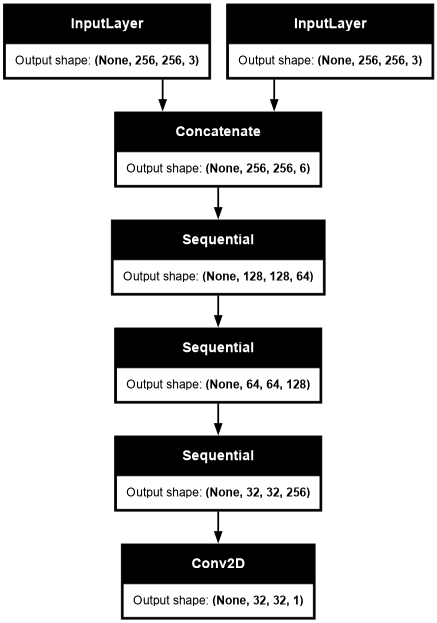

In [12]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64,to_file='discriminator.png')

## Discriminator loss

In [13]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

# Model training

In [14]:
generator_optimizer = tf.keras.optimizers.Adam()#(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam()#(2e-4, beta_1=0.5)

In [15]:
@tf.function
def train_step(input_images,target_images,epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        ##TRAIN THE GENERATOR
        gen_output = generator(input_images, training=True) #generates image
        disc_gen_output = discriminator([input_images,gen_output], training=True) #get the disriminator output of generated image
        gen_total_loss, _, _ = generator_loss(disc_gen_output, gen_output, target_images) #get the loss function
        #apply gradient
        generator_gradients = gen_tape.gradient(gen_total_loss,generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))

        ##TRAIN THE DISCRIMINATOR
        disc_real_output = discriminator([input_images,target_images], training=True) #get the discriminator output of real image
        disc_loss = discriminator_loss(disc_real_output, disc_gen_output) #get the loss function
        #apply gradient
        discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))
    return gen_total_loss,disc_loss

In [16]:
def train(train_dataset,epochs=56):
    for epoch in range(epochs):
        start = time.time()
        #train the model
        for batch in train_dataset:
            #convert the input images
            input_images = []
            target_images = []
            #print(batch.shape)

            for image_pair in batch:
                input_image = image_pair[0]
                target_image = image_pair[1]
                #form the input images
                input_images.append(input_image)

                #for the target images
                target_images.append(target_image)

            input_images = tf.convert_to_tensor(input_images)
            target_images = tf.convert_to_tensor(target_images)

            gen_loss, disc_loss = train_step(input_images,target_images,epoch)

        if (epoch%5==0):
            print("epoch {} gen loss:{}, disc loss:{}".format(epoch,gen_loss, disc_loss))
            print("time taken for 5 epoch:{}s".format(time.time()-start))
            start = time.time()

train(train_set)

epoch 0 gen loss:21.145158767700195, disc loss:1.3385372161865234
time taken for 5 epoch:9.143929481506348s
epoch 5 gen loss:16.349567413330078, disc loss:1.1116769313812256
time taken for 5 epoch:4.42824649810791s
epoch 10 gen loss:27.08937644958496, disc loss:1.77334463596344
time taken for 5 epoch:4.219228982925415s
epoch 15 gen loss:19.540958404541016, disc loss:0.9898613691329956
time taken for 5 epoch:4.324430465698242s
epoch 20 gen loss:17.93446159362793, disc loss:1.156633973121643
time taken for 5 epoch:4.1694300174713135s
epoch 25 gen loss:16.908794403076172, disc loss:1.2161228656768799
time taken for 5 epoch:4.179696321487427s
epoch 30 gen loss:23.299612045288086, disc loss:0.9009131193161011
time taken for 5 epoch:4.111299276351929s
epoch 35 gen loss:9.98298168182373, disc loss:1.3762954473495483
time taken for 5 epoch:4.127321720123291s
epoch 40 gen loss:9.997308731079102, disc loss:1.1996684074401855
time taken for 5 epoch:4.283028602600098s
epoch 45 gen loss:10.93782806

# Model Testing

In [17]:
def denormalize(image):
  image = (image+1)
  image = image*127.5
  return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


141


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


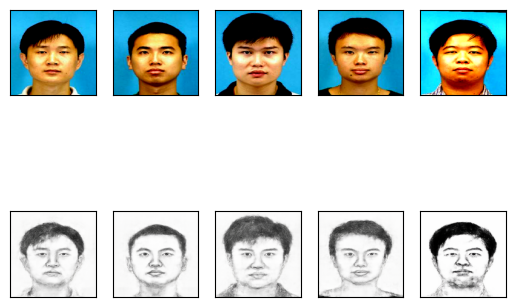

In [18]:
print(len(test_set))
temp_img_num = int(len(test_set)/2)
temp_img_num = 5

test_set1 = test_set.take(temp_img_num)
test_set2 = test_set.take(temp_img_num)

for step, (input_image, target_image) in test_set1.enumerate():
    ax = plt.subplot(2,temp_img_num,int(step)+1)
    plt.imshow(input_image)
    plt.xticks([])
    plt.yticks([])

    gen_output = generator(input_image[tf.newaxis, ...], training=False)
    ax = plt.subplot(2,temp_img_num,temp_img_num+int(step)+1)

    gen_output = gen_output[0,...]
    denorm_output = denormalize(gen_output)
    denorm_output = tf.cast(denorm_output,tf.int32)
    denorm_output = tf.clip_by_value(denorm_output,0,255)

    plt.imshow(denorm_output)
    plt.xticks([])
    plt.yticks([])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


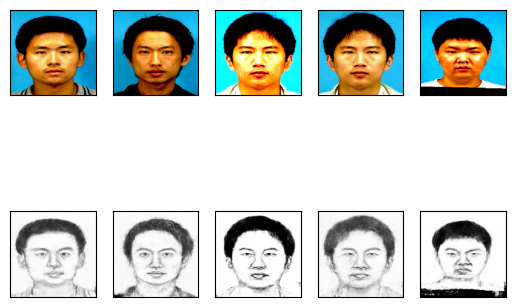

In [19]:
for step, (input_image, target_image) in test_set2.enumerate():
    ax = plt.subplot(2,temp_img_num,int(step)+1)
    plt.imshow(input_image)
    plt.xticks([])
    plt.yticks([])

    gen_output = generator(input_image[tf.newaxis, ...], training=False)
    ax = plt.subplot(2,temp_img_num,temp_img_num+int(step)+1)

    gen_output = gen_output[0,...]
    denorm_output = denormalize(gen_output)
    denorm_output = tf.cast(denorm_output,tf.int32)
    denorm_output = tf.clip_by_value(denorm_output,0,255)

    plt.imshow(denorm_output)
    plt.xticks([])
    plt.yticks([])

# Save the generator

In [20]:
generator.save("data/PortraitToSketch.keras")